In [1]:
import sys
sys.path.append('/home/inoue/inoue/github/STAD')

In [16]:
import numpy as np
import cv2
import torch
import albumentations as albu
import matplotlib.pyplot as plt

In [3]:
from torchvision import models
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from stad.datasets import MVTecDataset
from pathlib import Path
from tqdm import tqdm

In [4]:
DEVICE = 'cuda:0'
PATCH_SIZE = 128
TRAIN_BATCH_SIZE = 1
TEST_BATCH_SIZE = 64
EPOCHS = 100

<br>

## Define Teacher and Student Network

In [5]:
pretrained_vgg = models.vgg19(pretrained=True)
teacher = pretrained_vgg.features[:36]
teacher = teacher.to(DEVICE)

In [6]:
vgg = models.vgg19(pretrained=False)
student = vgg.features[:36]
student = student.to(DEVICE)

<br>

## Prepare Dataset

In [7]:
train_augs = [albu.HorizontalFlip(p=0.5),
              albu.RandomCrop(height=PATCH_SIZE, width=PATCH_SIZE, always_apply=True, p=1),
              albu.Normalize(always_apply=True, p=1),
              ToTensorV2()]
train_augs = albu.Compose(train_augs)

In [8]:
mvtec = MVTecDataset(img_dir=Path('/dgx/shared/momo/Data/MVTec/bottle/train/good'),
                     mask_dir=Path(''),
                     augs=train_augs,
                     is_anomaly=False)

train_loader = DataLoader(dataset=mvtec,
                          batch_size=TRAIN_BATCH_SIZE,
                          shuffle=True)

<br>

## Train Student Network

In [9]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

In [10]:
teacher.eval()

for epoch in tqdm(range(EPOCHS)):
    for img, arr, mask in train_loader:
         
        img = img.to(DEVICE)
        with torch.no_grad():
            surrogate_label = teacher(img)
        optimizer.zero_grad()
        pred = student(img)
        
        loss = criterion(pred, surrogate_label)
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [14:53<00:00,  8.94s/it]


<br>

## Compute Anomaly Map

In [11]:
test_augs = [albu.Normalize(always_apply=True, p=1),
             ToTensorV2()]
test_augs = albu.Compose(test_augs)

In [19]:
img_path = '/dgx/shared/momo/Data/MVTec/bottle/test/broken_small/000.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sample = test_augs(image=img)
img = sample['image']
img = img.unsqueeze(0)

unfold = torch.nn.Unfold(kernel_size=(PATCH_SIZE, PATCH_SIZE), stride=64)
patches = unfold(img)
patches = patches.permute(0, 2, 1).view(-1, 3, PATCH_SIZE, PATCH_SIZE)

In [20]:
teacher.eval()
student.eval()

patches_num = patches.shape[0]
anomaly_map = np.zeros(patches_num)
quotient, remainder = divmod(patches_num, TEST_BATCH_SIZE)
for i in tqdm(range(quotient)):
        
        start = i * TEST_BATCH_SIZE
        end = start + TEST_BATCH_SIZE
        
        patch = patches[start:end, :, :, :]
        patch = patch.to(DEVICE)
        
        surrogate_label = teacher(patch)
        pred = student(patch)
        
        losses = pred - surrogate_label
        losses = losses.view(TEST_BATCH_SIZE, -1)
        losses = losses.pow(2).mean(1)
        losses = losses.cpu().detach().numpy()
        
        anomaly_map[start:end] = losses


patch = patches[-remainder:, :, :, :]
patch = patch.to(DEVICE)
surrogate_label = teacher(patch)
pred = student(patch)

losses = pred - surrogate_label
losses = losses.view(remainder, -1)
losses = losses.pow(2).mean(1)
losses = losses.cpu().detach().numpy()

anomaly_map[-remainder:] = losses

100%|██████████| 2/2 [00:00<00:00, 12.91it/s]


In [14]:
b, c, h, w = img.shape
anomaly_map = anomaly_map.reshape(h-PATCH_SIZE+1, w-PATCH_SIZE+1)
anomaly_map = np.pad(anomaly_map, ((PATCH_SIZE//2, PATCH_SIZE//2-1), (PATCH_SIZE//2, PATCH_SIZE//2-1)), 'constant')

<br>

# Visualize Image, Mask and Anomaly Map

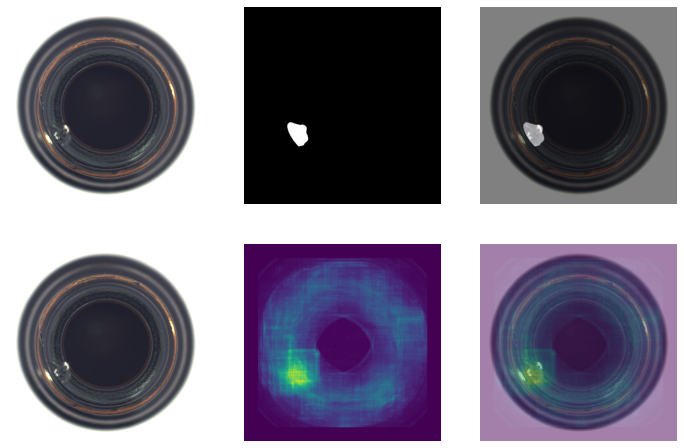

In [17]:
img = cv2.imread('/dgx/shared/momo/Data/MVTec/bottle/test/broken_small/000.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread('/dgx/shared/momo/Data/MVTec/bottle/ground_truth/broken_small/000_mask.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(img)
plt.axis('off')

plt.subplot(232)
plt.imshow(mask)
plt.axis('off')

plt.subplot(233)
plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.axis('off')

plt.subplot(234)
plt.imshow(img)
plt.axis('off')

plt.subplot(235)
plt.imshow(anomaly_map)
plt.axis('off')

plt.subplot(236)
plt.imshow(img)
plt.imshow(anomaly_map, alpha=0.5)
plt.axis('off')

plt.show()